In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
from IPython.display import display
from sklearn.externals import joblib

basepath = os.path.expanduser('../')

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

## Hypothesis

## Load Data

In [4]:
%%time

app_train   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/application_train.pkl'))
app_test    = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/application_test.pkl'))

# additional tables

bureau       = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/bureau.pkl'))
bureau_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/bureau_balance.pkl'))
prev_app     = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/previous_application.pkl'))
installments = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/installments_payments.pkl')) 
pos_cash     = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/POS_CASH_balance.pkl'))
credit_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/credit_card_balance.pkl'))

CPU times: user 607 ms, sys: 2.23 s, total: 2.84 s
Wall time: 26.3 s


In [5]:
app_train.TARGET.value_counts(normalize=True)

0.0    0.919271
1.0    0.080729
Name: TARGET, dtype: float64

In [8]:
print(app_train.shape, ' ', app_train.SK_ID_CURR.nunique())
display_all(app_train.head())

(307511, 122)   307511


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,0.024704,0.024994,0.025208,0.036896,0.036896,0.038300,0,1.0,M,0.014297,0.014397,0.014397,-9461,-637,-2120,-1134.0,-3648.0,2.0,2.0,0.000000,0.000000,0.000000,No,0.068970,0.068970,0.068970,0.083008,0.262939,0.139404,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,N,Y,1,0,0.083313,0.083313,0.083313,0.125000,0.125000,0.125000,reg oper account,10,block of flats,0.036896,0.037506,0.037689,0,0,0.020203,0.020493,0.022003,0.018997,0.019302,0.019806,Cash loans,Secondary / secondary special,Single / not married,House / apartment,Working,Unaccompanied,0.000000,0.000000,0.0,0.000000,0.000000,0.0,2.0,2.0,Laborers,Business Entity Type 3,NaN,0.018799,2,2,0,0,0,0,100002,1.0,0.014900,"Stone, brick",WEDNESDAY,0.972168,0.972168,0.972168,0.619141,0.624512,0.634277
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095886,0.096802,0.092407,0.052887,0.052887,0.053802,0,2.0,F,0.060486,0.060791,0.049713,-16765,-1188,-291,-828.0,-1186.0,0.0,0.0,0.080017,0.080017,0.080627,No,0.034485,0.034485,0.034485,0.311279,0.622070,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,N,N,1,0,0.291748,0.291748,0.291748,0.333252,0.333252,0.333252,reg oper account,11,block of flats,0.013000,0.013199,0.012802,0,0,0.077271,0.078674,0.078979,0.054901,0.055786,0.055389,Cash loans,Higher education,Married,House / apartment,State servant,Family,0.003901,0.003901,0.0,0.009804,0.010002,0.0,1.0,1.0,Core staff,School,NaN,0.003542,1,1,0,0,0,0,100003,0.0,0.071411,Block,MONDAY,0.984863,0.984863,0.984863,0.795898,0.798828,0.804199
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,M,NaN,NaN,NaN,-19046,-225,-2531,-815.0,-4260.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.556152,0.729492,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [10]:
print(prev_app.shape, ' ', prev_app.SK_ID_CURR.nunique(), ' ', prev_app.SK_ID_PREV.nunique())
display_all(prev_app.head())

(1670214, 37)   338857   1670214


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182861,0.867188,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


### Look at client's information

In [10]:
app_train[app_train.TARGET == 1].sample(frac=1.)['SK_ID_CURR'].iloc[:5]

187028    316817
6153      107188
66569     177197
129070    249712
53110     161509
Name: SK_ID_CURR, dtype: int32

In [16]:
SK_ID_CURR = [107188]

In [17]:
display_all(app_train[app_train.SK_ID_CURR == SK_ID_CURR].T)

,6153
AMT_ANNUITY,9000
AMT_CREDIT,180000
AMT_GOODS_PRICE,180000
AMT_INCOME_TOTAL,135000
AMT_REQ_CREDIT_BUREAU_DAY,0
AMT_REQ_CREDIT_BUREAU_HOUR,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_QRT,0
AMT_REQ_CREDIT_BUREAU_WEEK,0
AMT_REQ_CREDIT_BUREAU_YEAR,1


In [18]:
display_all(prev_app.loc[prev_app.SK_ID_CURR == SK_ID_CURR].T)

,1055600
SK_ID_PREV,1830238
SK_ID_CURR,107188
NAME_CONTRACT_TYPE,Consumer loans
AMT_ANNUITY,6513.12
AMT_APPLICATION,53190
AMT_CREDIT,59269.5
AMT_DOWN_PAYMENT,0
AMT_GOODS_PRICE,53190
WEEKDAY_APPR_PROCESS_START,TUESDAY
HOUR_APPR_PROCESS_START,19


In [16]:
display_all(pos_cash.loc[pos_cash.SK_ID_CURR == SK_ID_CURR].T)

,447986,1246419,1562565,2811718,2940044,3172310,3505965,4853272,5304038,6167273,6169814,6219826,6539839,6540965,6541318,6574725,6673292,6793565,7104506,7359039,7926772,8089031,8277705,8324628,8418656,8495725,8528176,9034273,9289918,9292442,9865685
SK_ID_PREV,1885239,1185379,1885239,1885239,1885239,1185379,1885239,1885239,1185379,1885239,1885239,1185379,1885239,1885239,1885239,1885239,1885239,1885239,1185379,1885239,1185379,1885239,1885239,1885239,1885239,1185379,1885239,1885239,1885239,1885239,1885239
SK_ID_CURR,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137,311137
MONTHS_BALANCE,-27,-21,-26,-34,-36,-22,-25,-28,-23,-33,-31,-25,-18,-14,-15,-23,-24,-37,-26,-20,-24,-17,-16,-21,-22,-20,-32,-29,-35,-30,-19
CNT_INSTALMENT,24,6,24,24,24,6,24,24,6,24,24,6,24,23,24,24,24,24,6,24,6,24,24,24,24,6,24,24,24,24,24
CNT_INSTALMENT_FUTURE,14,0,13,21,23,1,12,15,3,20,18,5,5,0,2,10,11,24,6,7,4,4,3,8,9,0,19,16,22,17,6
NAME_CONTRACT_STATUS,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Completed,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,Completed,Active,Active,Active,Active,Active
SK_DPD,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SK_DPD_DEF,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Hypothesis:

1. Difference between first bureau credit and employment date.
1. Difference between first bureau credit and age.

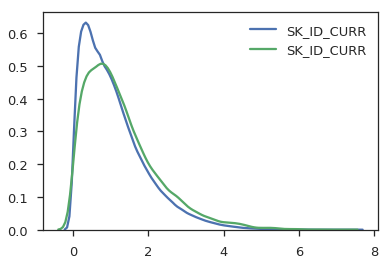

In [13]:
t1 = prev_app[prev_app.NAME_CONTRACT_STATUS == 'Approved'].groupby('SK_ID_CURR')['DAYS_DECISION'].max()
t2 = bureau.groupby('SK_ID_CURR')['DAYS_CREDIT'].max()

t1 = app_train.SK_ID_CURR.map(t1)
t2 = app_train.SK_ID_CURR.map(t2)

sns.kdeplot((t1 / t2)[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot((t1 / t2)[app_train.TARGET == 1].map(np.log1p));

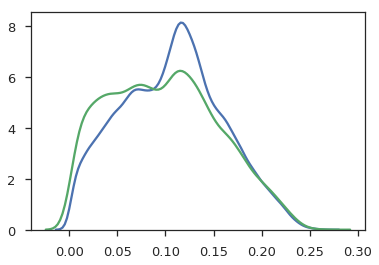

In [7]:
t1 = bureau.groupby('SK_ID_CURR')['DAYS_CREDIT'].min()
t1 = app_train.SK_ID_CURR.map(t1)
t2 = app_train.DAYS_BIRTH

sns.kdeplot((t1 / t2)[app_train.TARGET == 0].map(np.log1p))
sns.kdeplot((t1 / t2)[app_train.TARGET == 1].map(np.log1p));

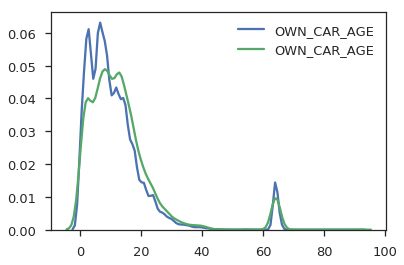

In [49]:
sns.kdeplot(app_train[app_train.TARGET == 0].OWN_CAR_AGE)
sns.kdeplot(app_train[app_train.TARGET == 1].OWN_CAR_AGE);

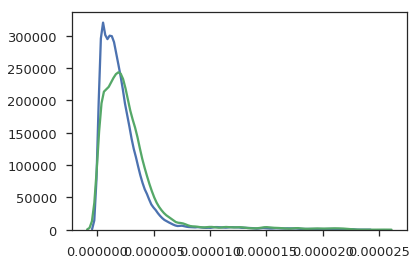

In [50]:
sns.kdeplot(app_train[app_train.TARGET == 0].OWN_CAR_AGE / -app_train[app_train.TARGET == 0].DAYS_BIRTH / 365)
sns.kdeplot(app_train[app_train.TARGET == 1].OWN_CAR_AGE / -app_train[app_train.TARGET == 1].DAYS_BIRTH / 365);

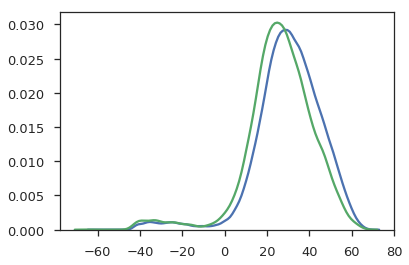

In [55]:
sns.kdeplot((-app_train[app_train.TARGET == 0].DAYS_BIRTH / 365) - app_train[app_train.TARGET == 0].OWN_CAR_AGE)
sns.kdeplot((-app_train[app_train.TARGET == 1].DAYS_BIRTH / 365) - app_train[app_train.TARGET == 1].OWN_CAR_AGE);

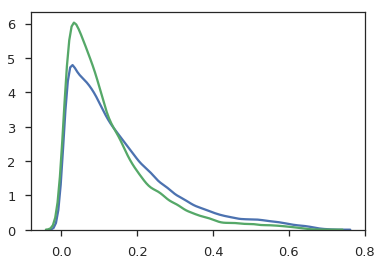

In [54]:
sns.kdeplot((-app_train[app_train.TARGET == 0].DAYS_EMPLOYED.replace({365243: np.nan}) / 365) / (-app_train[app_train.TARGET == 0].DAYS_BIRTH / 365))
sns.kdeplot((-app_train[app_train.TARGET == 1].DAYS_EMPLOYED.replace({365243: np.nan}) / 365) / (-app_train[app_train.TARGET == 1].DAYS_BIRTH / 365));